'Processing TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs'


  0%|          | 0/66 [00:00<?, ?it/s]

'Task finished successfully'


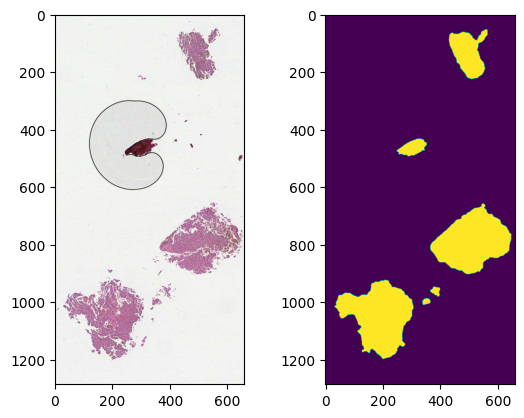

In [7]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt
input_wsi = "/home/u1910100/Documents/tcga/test/vis/slides/TCGA-A4-7288-01Z-00-DX1.48597193-160b-486a-9711-f26d24dabeb5.svs"
save_dir = "./output"
model_weight_path = "tissue_masker_lite/model_weights/model_22.pth"
mask = get_mask(
    wsi_path=input_wsi,
    save_dir=save_dir,
    model_weight=model_weight_path,
    threshold=0.5,
    cuda=True,
    return_mask=True,
    save_mask=False,
)
reader = WSIReader.open(input_wsi)
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
fig, axes = plt.subplots(1, 2)
axes[0].imshow(thumbnail)
axes[1].imshow(mask)
plt.show()